In [10]:
import pandas as pd
import numpy as np
import math
import random

In [2]:
class Node():
	"""
	Node of decision tree

	Parameters:
	-----------
	prediction: int
		Class prediction at this node
	feature: int
		Index of feature used for splitting on
	split: int
		Categorical value for the threshold to split on for the feature
	left_tree: Node
		Left subtree
	right_tree: Node
		Right subtree
	"""
	def __init__(self, prediction, feature, split, left_tree, right_tree):
		self.prediction = prediction
		self.feature = feature
		self.split = split
		self.left_tree = left_tree
		self.right_tree = right_tree



In [3]:

def entropy(target_col):
    """
    This function takes target_col, which is the data column containing the class labels, and returns H(Y).

    """
    py0 = len(np.where(target_col==0)[0])/len(target_col)
    py1 = len(np.where(target_col==1)[0])/len(target_col)
    
    if py0 == 0 and py1 == 0:
        entropy = 0
    elif py0 == 0:
        entropy = -(py1*np.log2(py1))
    elif py1 == 0:
        entropy = -(py0*np.log2(py0))
    else:
        entropy = -(py0*np.log2(py0) + py1*np.log2(py1))

    return entropy

In [4]:

def InfoGain(data,split_attribute_name,target_name="class"):
    """
    This function calculates the information gain of specified feature. This function takes three parameters:
    1. data = The dataset for whose feature the IG should be calculated
    2. split_attribute_name = the name of the feature for which the information gain should be calculated
    3. target_name = the name of the target feature. The default for this example is "class"
    """
    # before entropy
    before = entropy(data[target_name].to_numpy())

#     data split  df1 -> class = 1 / df2 -> class = 0
    if len([x for _, x in data.groupby(data.iloc[:,split_attribute_name] >= 1)]) == 1:
        Information_Gain = 0
        
    else:
        split_data1, split_data2 = [x for _, x in data.groupby(data.iloc[:,split_attribute_name] >= 1)]
    
        s_data1_entropy = (len(split_data1)/len(data))*entropy(split_data1[target_name].to_numpy())
        s_data2_entropy = (len(split_data2)/len(data))*entropy(split_data2[target_name].to_numpy())

        Information_Gain = before - s_data1_entropy - s_data2_entropy

    return Information_Gain


In [12]:
# tree가 노드

# example하나 넣으면 트리에서 recursive하게 찾아서 노드의 prediction을 리턴
def predict(example,tree,prediction_list,default = 1):
    """
    This function handles making prediction for an example, takes two parameters:
    1. The example

    2. The tree, which is a node
    This needs to be done in a recursive manner. First check if the node is a leaf, if so, return the prediction of the node. Otherwise, send the example down the appropriate subbranch with recursive call.
    """
    if tree.feature == None:
        prediction_list.append(tree.prediction)
    elif example[tree.feature] == 0:
        predict(example,tree.left_tree,prediction_list)
    else:
        predict(example,tree.right_tree,prediction_list)
        

In [13]:

# data로 decisiontree 들어있는 root node만들고 root node 리턴
def RandomForest(data,features, depth, maxdepth, m, target_attribute_name="class"):
    """
    This function takes following paramters:
    1. data = the data for which the decision tree building algorithm should be run --> In the first run this equals the total dataset

    2. features = the feature space of the dataset . This is needed for the recursive call since during the tree growing process
    we have to remove features from our dataset once we have splitted on a feature

    3. target_attribute_name = the name of the target attribute
    4. depth = the current depth of the node in the tree --- this is needed to remember where you are in the overall tree
    5. maxdepth =  the stopping condition for growing the tree

    """    
    
    #First of all, define the stopping criteria here are some, depending on how you implement your code, there maybe more corner cases to consider
    """
    1. If max depth is met, return a leaf node labeled with majority class, additionally
    2. If all target_values have the same value (pure), return a leaf node labeled with majority class 
    3. If the remaining feature space is empty, return a leaf node labeled with majority class
    """
    
    leaf = True
    check = 0
    for fea in features:
        if data.iloc[:,fea].value_counts().max() < len(data):
            check = fea
            leaf = False
            break
            
            
    if(depth == maxdepth or leaf== True or len(features) == 0):
        predict = data.loc[:,target_attribute_name].value_counts().idxmax()
#         print(predict)
        node = Node(predict, None, None, None, None)
        return node
    
    #If none of the above holds true, grow the tree!
    #First, select the feature which best splits the dataset
    gain = {'idx': None, 'value': 0}
    feat_temp = random.sample(features, m)

    for attr_idx in feat_temp:
        attr_gain = InfoGain(data, attr_idx, target_name="class")
        if attr_gain >= gain['value']:
            gain['idx'] = attr_idx
            gain['value'] = attr_gain
            
#     print("index : ",gain['idx'])
#     print("value : ",gain['value'])

    #Once best split is decided, do the following: 
    """
    1. create a node to store the selected feature 
    2. remove the selected feature from further consideration
    3. split the training data into the left and right branches and grow the left and right branch by making appropriate cursive calls
    4. return the completed node
    """
    if gain['value'] == 0:
        gain['idx'] = check

    data0, data1 = [x for _, x in data.groupby(data.iloc[:,gain['idx']] >= 1)]
    
    features.remove(gain['idx'])
    depth += 1
    
    node = Node(None,gain['idx'], None, RandomForest(data0,features,depth,maxdepth,m), RandomForest(data1,features,depth,maxdepth,m))
    
    return node

In [14]:
def calculte_accuracy(data,val_data,tree_list,num_T):

    T = random.sample(range(0, 50), num_T)
    predict_list = []
    val_predict_list = []
    
    for ex in range(len(data)):
        vote_list = []
        count_list = []

        for _ in T:
            predict(data.iloc[ex,:],tree_list[_],vote_list)

        count0 = vote_list.count(0)
        count1 = vote_list.count(1)

        count_list.append(count0)
        count_list.append(count1)
        max_value = max(count_list)
        max_index = count_list.index(max_value)

        predict_list.append(max_index)

    class_value = data['class'].values.tolist()

    count = 0
    for i in range(len(predict_list)):
        if predict_list[i] == class_value[i]:
            count += 1

    predict_acc = count / len(predict_list)
    print("\n===========result==========")
    print(predict_acc)
    
    for ex in range(len(val_data)):
        vote_list = []
        count_list = []

        for _ in T:
            predict(val_data.iloc[ex,:],tree_list[_],vote_list)

        count0 = vote_list.count(0)
        count1 = vote_list.count(1)

        count_list.append(count0)
        count_list.append(count1)
        max_value = max(count_list)
        max_index = count_list.index(max_value)

        val_predict_list.append(max_index)

    class_value = val_data['class'].values.tolist()

    count1 = 0
    for i in range(len(val_predict_list)):
        if val_predict_list[i] == class_value[i]:
            count1 += 1

    val_predict_acc = count1 / len(val_predict_list)
    print("\n===========result==========")
    print(val_predict_acc)
    
    
    
    return predict_acc, val_predict_acc


In [15]:
def make_tree_dummy(data,m,dmax):
    # number of features
#     m = 5
#     dmax = 1

    tree_list = []
    for x in range(50):

        frac1 = data.sample(frac=2/3)
        frac2 = frac1.sample(frac=0.5)
        sample_data = pd.concat([frac1,frac2])
        sample_data = sample_data.reset_index()
        sample_data = sample_data.drop(['index'],axis=1)

        feat = [_ for _ in range(117)]

        tree = RandomForest(sample_data,feat, 0, dmax, m, target_attribute_name="class")
        tree_list.append(tree)
    
    return tree_list

==================m5 dmax1================

===========result==========
0.8186666666666667

===========result==========
0.82625

===========result==========
0.6995555555555556

===========result==========
0.690625

===========result==========
0.7462222222222222

===========result==========
0.7475

===========result==========
0.8364444444444444

===========result==========
0.819375

===========result==========
0.8244444444444444

===========result==========
0.810625
==================m10 dmax1================

===========result==========
0.8942222222222223

===========result==========
0.88125

===========result==========
0.8946666666666667

===========result==========
0.88375

===========result==========
0.9017777777777778

===========result==========
0.889375

===========result==========
0.92

===========result==========
0.909375

===========result==========
0.9004444444444445

===========result==========
0.885625
==================m25 dmax1================

===========result==========

<AxesSubplot:title={'center':'Validaton with dmax=1'}, xlabel='T', ylabel='Accuracy'>

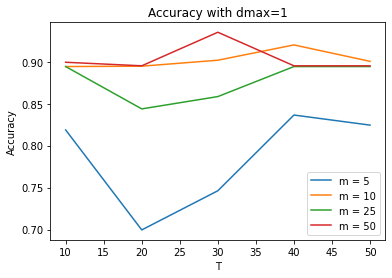

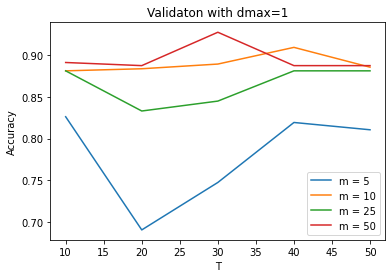

In [18]:
train = pd.read_csv('mushroom-train.csv')
validation = pd.read_csv('mushroom-val.csv')

print("==================m5 dmax1================")
m5_dm1 = []
acc51 = []
val51 = []
m5_dm1 = make_tree_dummy(train,5,1)
for T in [10,20,30,40,50]:
    train_predict, val_predict = calculte_accuracy(train,validation,m5_dm1,T)
    acc51.append(train_predict)
    val51.append(val_predict)

print("==================m10 dmax1================")
m10_dm1 = []
acc101 = []
val101 = []

m10_dm1 = make_tree_dummy(train,10,1)
for T in [10,20,30,40,50]:
    train_predict, val_predict = calculte_accuracy(train,validation,m10_dm1,T)
    acc101.append(train_predict)
    val101.append(val_predict)
    
print("==================m25 dmax1================")
m25_dm1 = []
acc251 = []
val251 = []

m25_dm1 = make_tree_dummy(train,25,1)
for T in [10,20,30,40,50]:
    train_predict, val_predict = calculte_accuracy(train,validation,m25_dm1,T)
    acc251.append(train_predict)
    val251.append(val_predict)
    
print("==================m50 dmax1================")
m50_dm1 = []
acc501 = []
val501 = []

m50_dm1 = make_tree_dummy(train,50,1)
for T in [10,20,30,40,50]:
    train_predict, val_predict = calculte_accuracy(train,validation,m50_dm1,T)
    acc501.append(train_predict)
    val501.append(val_predict)
    
graph = []
graph.append(acc51)
graph.append(acc101)
graph.append(acc251)
graph.append(acc501)

# p=1

numpy_array = np.array(graph)
transpose = numpy_array.T

spar_data = pd.DataFrame(transpose,columns=['m = 5','m = 10','m = 25','m = 50'],index=[10,20,30,40,50])
spar_data.plot(title="Accuracy with dmax=1",xlabel="T",ylabel="Accuracy")


graph = []
graph.append(val51)
graph.append(val101)
graph.append(val251)
graph.append(val501)

# p=1

numpy_array = np.array(graph)
transpose = numpy_array.T

spar_data = pd.DataFrame(transpose,columns=['m = 5','m = 10','m = 25','m = 50'],index=[10,20,30,40,50])
spar_data.plot(title="Validaton with dmax=1",xlabel="T",ylabel="Accuracy")

==================m5 dmax2================

===========result==========
0.8928888888888888

===========result==========
0.878125

===========result==========
0.8995555555555556

===========result==========
0.89

===========result==========
0.9197777777777778

===========result==========
0.914375

===========result==========
0.9004444444444445

===========result==========
0.8875

===========result==========
0.8942222222222223

===========result==========
0.88125
==================m10 dmax2================

===========result==========
0.9275555555555556

===========result==========
0.923125

===========result==========
0.9304444444444444

===========result==========
0.921875

===========result==========
0.9124444444444444

===========result==========
0.901875

===========result==========
0.8966666666666666

===========result==========
0.885625

===========result==========
0.9017777777777778

===========result==========
0.890625
==================m25 dmax2================

===========resu

<AxesSubplot:title={'center':'Validaton with dmax=2'}, xlabel='T', ylabel='Accuracy'>

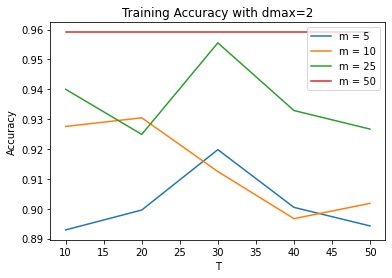

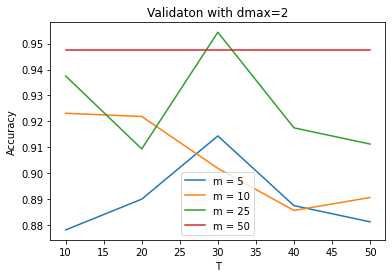

In [25]:
train = pd.read_csv('mushroom-train.csv')
validation = pd.read_csv('mushroom-val.csv')

print("==================m5 dmax2================")
m5_dm2 = []
acc52 = []
val52 = []
m5_dm2 = make_tree_dummy(train,5,2)
for T in [10,20,30,40,50]:
    train_predict, val_predict = calculte_accuracy(train,validation,m5_dm2,T)
    acc52.append(train_predict)
    val52.append(val_predict)

print("==================m10 dmax2================")
m10_dm2 = []
acc102 = []
val102 = []

m10_dm2 = make_tree_dummy(train,10,2)
for T in [10,20,30,40,50]:
    train_predict, val_predict = calculte_accuracy(train,validation,m10_dm2,T)
    acc102.append(train_predict)
    val102.append(val_predict)
    
print("==================m25 dmax2================")
m25_dm2 = []
acc252 = []
val252 = []

m25_dm2 = make_tree_dummy(train,25,2)
for T in [10,20,30,40,50]:
    train_predict, val_predict = calculte_accuracy(train,validation,m25_dm2,T)
    acc252.append(train_predict)
    val252.append(val_predict)
    
print("==================m50 dmax2================")
m50_dm2 = []
acc502 = []
val502 = []

m50_dm2 = make_tree_dummy(train,50,2)
for T in [10,20,30,40,50]:
    train_predict, val_predict = calculte_accuracy(train,validation,m50_dm2,T)
    acc502.append(train_predict)
    val502.append(val_predict)
    
graph = []
graph.append(acc52)
graph.append(acc102)
graph.append(acc252)
graph.append(acc502)

# p=1

numpy_array = np.array(graph)
transpose = numpy_array.T

spar_data = pd.DataFrame(transpose,columns=['m = 5','m = 10','m = 25','m = 50'],index=[10,20,30,40,50])
spar_data.plot(title="Training Accuracy with dmax=2",xlabel="T",ylabel="Accuracy")


graph = []
graph.append(val52)
graph.append(val102)
graph.append(val252)
graph.append(val502)

# p=1

numpy_array = np.array(graph)
transpose = numpy_array.T

spar_data = pd.DataFrame(transpose,columns=['m = 5','m = 10','m = 25','m = 50'],index=[10,20,30,40,50])
spar_data.plot(title="Validaton with dmax=2",xlabel="T",ylabel="Accuracy")

==================m5 dmax5================

===========result==========
0.9066666666666666

===========result==========
0.899375

===========result==========
0.9608888888888889

===========result==========
0.958125

===========result==========
0.9511111111111111

===========result==========
0.94625

===========result==========
0.952

===========result==========
0.9475

===========result==========
0.9702222222222222

===========result==========
0.966875
==================m10 dmax5================

===========result==========
0.9995555555555555

===========result==========
0.99875

===========result==========
0.992

===========result==========
0.986875

===========result==========
0.9951111111111111

===========result==========
0.99125

===========result==========
0.9931111111111111

===========result==========
0.9875

===========result==========
0.992

===========result==========
0.986875
==================m25 dmax5================

===========result==========
0.9957777777777778

======

<AxesSubplot:title={'center':'Validaton with dmax=5'}, xlabel='T', ylabel='Accuracy'>

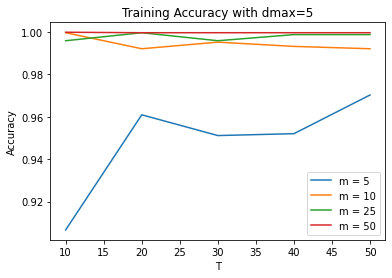

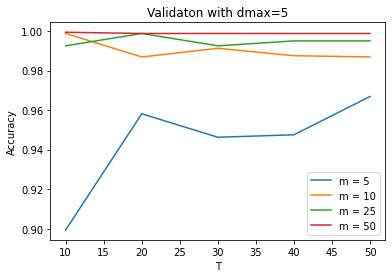

In [23]:
train = pd.read_csv('mushroom-train.csv')
validation = pd.read_csv('mushroom-val.csv')

print("==================m5 dmax5================")
m5_dm5 = []
acc55 = []
val55 = []
m5_dm5 = make_tree_dummy(train,5,5)
for T in [10,20,30,40,50]:
    train_predict, val_predict = calculte_accuracy(train,validation,m5_dm5,T)
    acc55.append(train_predict)
    val55.append(val_predict)

print("==================m10 dmax5================")
m10_dm5 = []
acc105 = []
val105 = []

m10_dm5 = make_tree_dummy(train,10,5)
for T in [10,20,30,40,50]:
    train_predict, val_predict = calculte_accuracy(train,validation,m10_dm5,T)
    acc105.append(train_predict)
    val105.append(val_predict)
    
print("==================m25 dmax5================")
m25_dm5 = []
acc255 = []
val255 = []

m25_dm5 = make_tree_dummy(train,25,5)
for T in [10,20,30,40,50]:
    train_predict, val_predict = calculte_accuracy(train,validation,m25_dm5,T)
    acc255.append(train_predict)
    val255.append(val_predict)
    
print("==================m50 dmax5================")
m50_dm5 = []
acc505 = []
val505 = []

m50_dm5 = make_tree_dummy(train,50,5)
for T in [10,20,30,40,50]:
    train_predict, val_predict = calculte_accuracy(train,validation,m50_dm5,T)
    acc505.append(train_predict)
    val505.append(val_predict)
    
graph = []
graph.append(acc55)
graph.append(acc105)
graph.append(acc255)
graph.append(acc505)

# p=1

numpy_array = np.array(graph)
transpose = numpy_array.T

spar_data = pd.DataFrame(transpose,columns=['m = 5','m = 10','m = 25','m = 50'],index=[10,20,30,40,50])
spar_data.plot(title="Training Accuracy with dmax=5",xlabel="T",ylabel="Accuracy")


graph = []
graph.append(val55)
graph.append(val105)
graph.append(val255)
graph.append(val505)

# p=1

numpy_array = np.array(graph)
transpose = numpy_array.T

spar_data = pd.DataFrame(transpose,columns=['m = 5','m = 10','m = 25','m = 50'],index=[10,20,30,40,50])
spar_data.plot(title="Validaton with dmax=5",xlabel="T",ylabel="Accuracy")